In [1]:
import re
import os
import time
import numpy as np
import pandas as pd
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50

### Reading the data and droppping useless columns

In [2]:
data_unprocessed_news = pd.read_excel('data.xlsx')
data_unprocessed_news.head()

,short,long,Source,Time,Publish Date
0,The CBI on Saturday booked four former officia...,4 ex-bank officials booked for cheating bank o...,The New Indian Express,09:25:00,2017-03-26
1,Chief Justice JS Khehar has said the Supreme C...,Supreme Court to go paperless in 6 months: CJI,Outlook,22:18:00,2017-03-25
2,"At least three people were killed, including a...","At least 3 killed, 30 injured in blast in Sylh...",Hindustan Times,23:39:00,2017-03-25
3,Mukesh Ambani-led Reliance Industries (RIL) wa...,Why has Reliance been barred from trading in f...,Livemint,23:08:00,2017-03-25
4,TV news anchor Arnab Goswami has said he was t...,Was stopped from entering my own studio at Tim...,YouTube,23:24:00,2017-03-25


In [3]:
from sklearn.utils import shuffle
data_unprocessed_news = shuffle(data_unprocessed_news)
data_unprocessed_news.head()

,short,long,Source,Time,Publish Date
16354,As much as 10 lakh kilograms of toxic chilli p...,10 lakh kg of toxic chilli powder seized in An...,The New Indian Express,22:28:00,2016-12-10
968,Speaking at the International Buddhist confere...,Buddha’s teachings more relevant than ever bef...,Hindustan Times,10:04:00,2017-03-20
28212,The Kolarbyn Eco-Lodge offers guests the chanc...,Hostel in Sweden has wooden charcoal-burner huts,Kolarbyn Eco-lodge,15:07:00,2016-09-29
41685,Former Indian bowler Anil Kumble has filed his...,Anil Kumble files nomination for India coach job,Sportskeeda,12:22:00,2016-06-14
13654,Income Tax department officials have reportedl...,Assets worth ₹169 crore found in I-T raid on 2...,The New Indian Express,22:45:00,2016-12-28


In [4]:
summaries, longreview = pd.DataFrame(), pd.DataFrame()
summaries['short'] = data_unprocessed_news['short']
longreview['long'] = data_unprocessed_news['long']
(summaries.shape,longreview.shape)

((55104, 1), (55104, 1))

### Cleaning the data for training

In [5]:

def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence)
    sentence = re.sub(r"&34", "", sentence)
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [6]:
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))

In [7]:
longreview.head()

,long
16354,lakh kg of toxic chilli powder seized in andhr...
968,buddhas teachings more relevant than ever befo...
28212,hostel in sweden has wooden charcoalburner huts
41685,anil kumble files nomination for india coach job
13654,assets worth crore found in it raid on realt...


In [8]:

start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

,short
16354,<startseq> as much as lakh kilograms of toxic...
968,<startseq> speaking at the international buddh...
28212,<startseq> the kolarbyn ecolodge offers guests...
41685,<startseq> former indian bowler anil kumble ha...
13654,<startseq> income tax department officials hav...


In [9]:
val_split = 0.1

summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]
longreview_train = longreview[int(len(summaries)*val_split):]
longreview_val = longreview[:int(len(summaries)*val_split)]

len(longreview_val),len(longreview_train)

(5510, 49594)

In [10]:
longreview_train.iloc[0], summaries_train.iloc[0]

(long    girls in top  jee main  ranks
 Name: 40544, dtype: object,
 short    <startseq> out of the top  positions in the je...
 Name: 40544, dtype: object)

finding the maximum length of questions and answers

In [11]:

def max_length(shorts, longs, prct):


    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

max_len_news, max_len_summary= max_length(summaries_train['short'].to_list(), longreview_train['long'].to_list(), 90)


print('max-length longreview chosen for training: ', max_len_news)
print('max-length summaries chosen for training: ', max_len_summary)

percentile 90 of length of news: 10.0
longest sentence:  14

percentile 90 of length of summaries: 62.0
longest sentence:  68

max-length longreview chosen for training:  10
max-length summaries chosen for training:  62


### Dataset prepration


In [12]:

def create_vocab(shorts, longs = None, minimum_repeat = 3):

    all_captions = []
    for s in shorts:
        all_captions.append(s)


    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat]

    vocab = list(set(vocab))
    return vocab

In [13]:

vocab_dec = create_vocab(summaries_train['short'].to_list(), minimum_repeat=5)

for v in vocab_dec:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_dec.remove(v)

vocab_dec = sorted(vocab_dec)[1:]
vocab_dec[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aadmi',
 'aai',
 'aaj',
 'aakash']

In [14]:

vocab_enc = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3)

for v in vocab_enc:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_enc.remove(v)

vocab_enc = sorted(vocab_enc)[1:]
vocab_enc[:10]

['a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aadmi',
 'aakash',
 'aam',
 'aamir',
 'aamirs',
 'aanand']

In [15]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
document_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)


encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

encoder_vocab_size, decoder_vocab_size

(12599, 23584)

In [16]:
ixtoword_enc = {}
ixtoword_dec = {}

wordtoix_enc = document_tokenizer.word_index
ixtoword_enc[0] = '<PAD0>'
ixtoword_dec[0] = '<PAD0>'

for w in document_tokenizer.word_index:
    ixtoword_enc[document_tokenizer.word_index[w]] = w

wordtoix_dec = summary_tokenizer.word_index

for w in summary_tokenizer.word_index:
    ixtoword_dec[summary_tokenizer.word_index[w]] = w

In [17]:

inputs = document_tokenizer.texts_to_sequences(longreview_train['long'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['short'])
inputs_val = document_tokenizer.texts_to_sequences(longreview_val['long'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['short'])

In [18]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')
inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [19]:

dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

In [20]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

### Defining the model

In [21]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')

    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

#### Scaled Dot Product
![](files/z-score.png)


In [22]:

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### multi-headed attention
![](files/multi-head.png)

In [32]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads


        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))


    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]


        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)


        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])


        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

#### positional encoding

In [31]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )


    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Layers

#### Embeddings preparation

In [33]:

def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= '/content/glove.6B.50d'):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim))
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {}
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()

        embedding_matrix = np.zeros((vocab_len, embedding_dim))
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:

                embedding_matrix[i] = embedding_vector

        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


#### transformer layers

In [34]:

init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1
num_layers = 4
d_model = embedding_dim
dff = 512
num_heads = 5

In [35]:

def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [36]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)


    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [37]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [38]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

In [39]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = krs.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

#### Final model

In [70]:

class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))


    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [41]:
transformer = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    encoder_vocab_size,
    decoder_vocab_size,
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

#### Masking


In [42]:

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [43]:

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)

    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

#### training

In [44]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=4000,
    decay_rate=0.95)

In [45]:

optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [46]:
def loss_function(real, pred, l2= False):

    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [47]:
checkpoint_path4 ="checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

# if ckpt_manager4.latest_checkpoint:
#     ckpt4.restore(ckpt_manager4.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

#### inference

In [48]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news,
                                                                           padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):

    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)
    return summary_tokenizer.sequences_to_texts(summarized)[0]

In [49]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)


        predictions, _ = transformer(
            inp, tar_inp,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()


In [50]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)


    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))


    train_loss(loss)

In [51]:
history={'val':[],'train':[]}
EPOCHS = 50
not_progressing = 0

train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [52]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [53]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 10.0812
Epoch 1 Batch 150 Loss 7.8587
Epoch 1 Batch 300 Loss 7.4494
Epoch 1 Batch 450 Loss 7.1966
Epoch 1 Batch 600 Loss 6.9905
Epoch 1 Batch 750 Loss 6.8318

the <UNK> <UNK> <UNK> has been released a <UNK> of the first year of the first year of the first year of the first year of the first year of the first year
the supreme court on monday said that the government has been been been been a <UNK> of the state of the state of the state of the state of the government of the government of the government of the state of the government of the government has been been been been been been been been been been been arrested in the court
the government has been arrested to the government of the government of the government of the government of the government of the government of the government has been been been been been

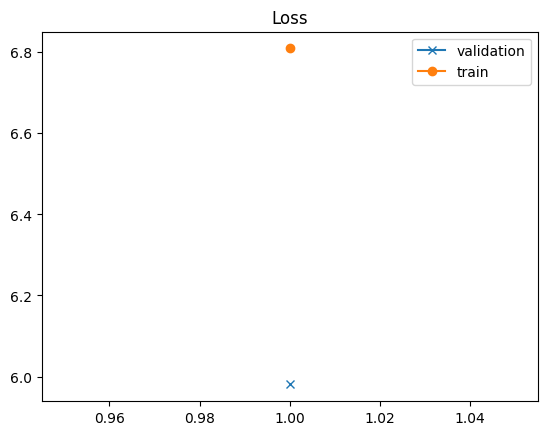

smallest val loss: (1, 5.9806104)
Current Lr:  0.0009901238

Time taken for this epoch: 135.78 secs

Epoch 2 Batch 0 Loss 6.0918
Epoch 2 Batch 150 Loss 6.0062
Epoch 2 Batch 300 Loss 5.9544
Epoch 2 Batch 450 Loss 5.9094
Epoch 2 Batch 600 Loss 5.8694
Epoch 2 Batch 750 Loss 5.8338

the worlds largest <UNK> <UNK> has announced that the worlds largest <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on monday said that the supreme court on monday that the court has been arrested by the court on the court on saturday the court on saturday the court was arrested by the court on saturday the court was arrested by the court on the court on the court on the court
the supreme court on monday said that the supreme court on monday that the court has be

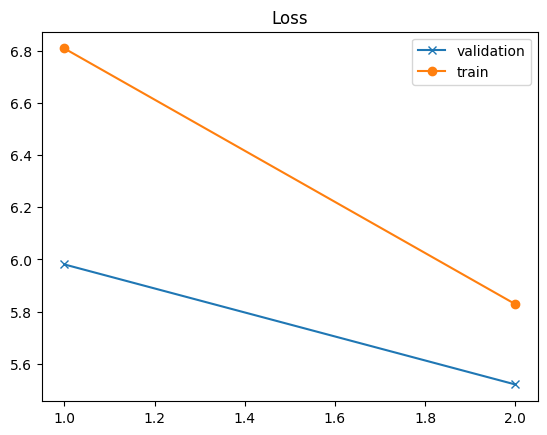

smallest val loss: (2, 5.520206)
Current Lr:  0.0009803326

Time taken for this epoch: 98.01 secs

Epoch 3 Batch 0 Loss 5.6248
Epoch 3 Batch 150 Loss 5.5926
Epoch 3 Batch 300 Loss 5.5706
Epoch 3 Batch 450 Loss 5.5459
Epoch 3 Batch 600 Loss 5.5295
Epoch 3 Batch 750 Loss 5.5129

the worlds largest <UNK> startup has launched a new <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on tuesday said that the supreme court has been arrested by the court on the court on the court on friday that the court was arrested by the court on the court on the court on the court on the court on the court on the court on the court on the court
the supreme court on tuesday said that the government has been the government to be the government to be held in the st

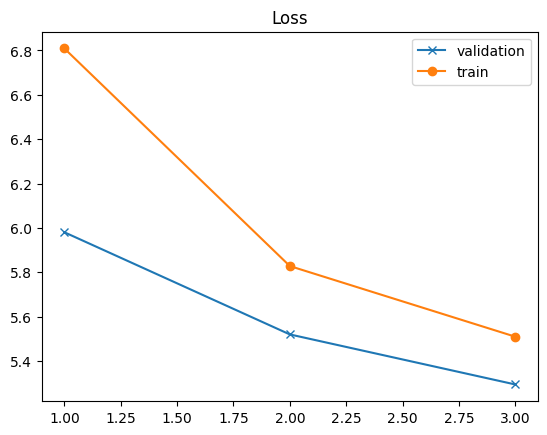

smallest val loss: (3, 5.294652)
Current Lr:  0.0009706383

Time taken for this epoch: 96.23 secs

Epoch 4 Batch 0 Loss 5.3860
Epoch 4 Batch 150 Loss 5.3709
Epoch 4 Batch 300 Loss 5.3616
Epoch 4 Batch 450 Loss 5.3499
Epoch 4 Batch 600 Loss 5.3406
Epoch 4 Batch 750 Loss 5.3326

the worlds largest <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> has been launched in the first time of the first time of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on monday arrested a yearold <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> was also been arrested in the case of the court the court had been arrested in the case
the election commission on monday announced that the government will be held in the assembly 

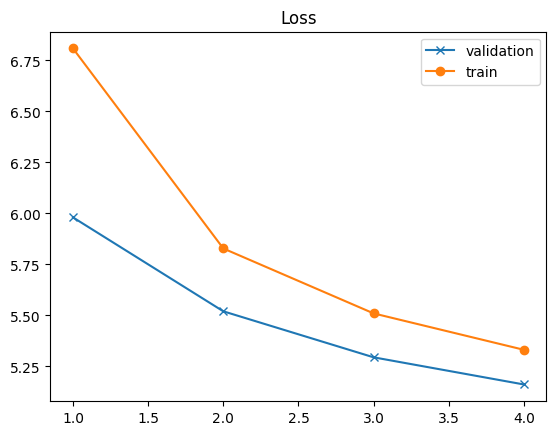

smallest val loss: (4, 5.1615124)
Current Lr:  0.00096103986

Time taken for this epoch: 96.07 secs

Epoch 5 Batch 0 Loss 5.2700
Epoch 5 Batch 150 Loss 5.2361
Epoch 5 Batch 300 Loss 5.2278
Epoch 5 Batch 450 Loss 5.2268
Epoch 5 Batch 600 Loss 5.2227
Epoch 5 Batch 750 Loss 5.2190

the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> has been unveiled in the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on wednesday ordered a notice to the supreme court on the court on wednesday ordered a notice to the court on the court on wednesday ordered a plea to the court on the court on the court on the court on wednesday directed the court to the court on the court on the court
the election commission on wednesday announced that the election commission has been released by the ele

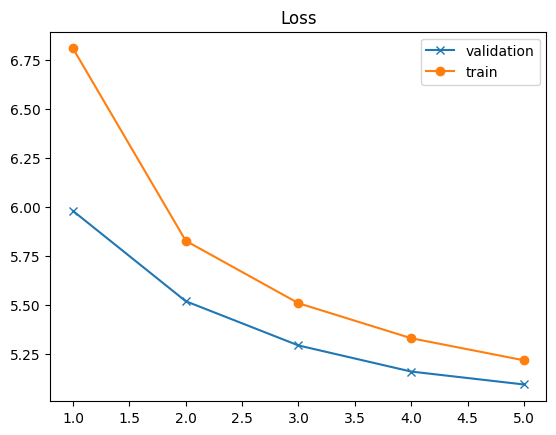

smallest val loss: (5, 5.095625)
Current Lr:  0.00095153623

Time taken for this epoch: 96.93 secs

Epoch 6 Batch 0 Loss 5.1069
Epoch 6 Batch 150 Loss 5.1543
Epoch 6 Batch 300 Loss 5.1427
Epoch 6 Batch 450 Loss 5.1457
Epoch 6 Batch 600 Loss 5.1436
Epoch 6 Batch 750 Loss 5.1432

the <UNK> company has been fined of the worlds largest <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> has been made by the company <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on thursday ordered a court to probe the court to probe the court on friday ordered a plea to probe into the court to probe the court on the court has been arrested in the case of the case of the case of the case of the case of the case was filed by the court
the election commission on tuesday announced that the assembly elections will be held in the assembly elections in the assembly ele

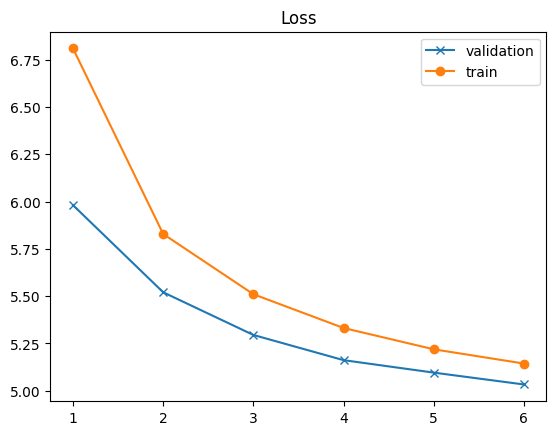

smallest val loss: (6, 5.032944)
Current Lr:  0.0009421266

Time taken for this epoch: 98.24 secs

Epoch 7 Batch 0 Loss 4.9900
Epoch 7 Batch 150 Loss 5.0922
Epoch 7 Batch 300 Loss 5.0890
Epoch 7 Batch 450 Loss 5.0883
Epoch 7 Batch 600 Loss 5.0893
Epoch 7 Batch 750 Loss 5.0876

the <UNK> company has unveiled a new <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on monday ordered a petition against the supreme court to probe the court on friday directed the court to the court to probe the court on the court has been sentenced to the case against the court in the case of the case of the court had earlier directed the court to the court
the election commission on tuesday announced that the assembly elections will be held in 

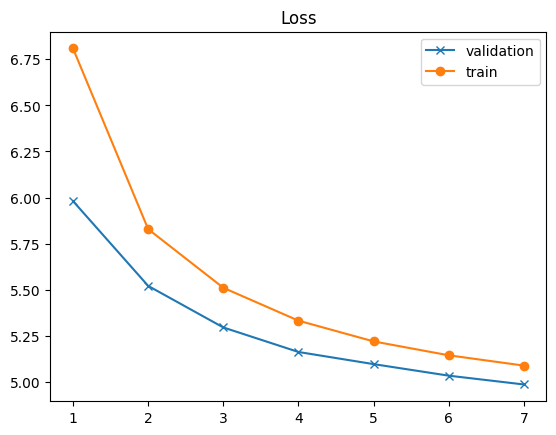

smallest val loss: (7, 4.9851613)
Current Lr:  0.0009328101

Time taken for this epoch: 96.71 secs

Epoch 8 Batch 0 Loss 4.9688
Epoch 8 Batch 150 Loss 5.0420
Epoch 8 Batch 300 Loss 5.0458
Epoch 8 Batch 450 Loss 5.0441
Epoch 8 Batch 600 Loss 5.0454
Epoch 8 Batch 750 Loss 5.0469

the <UNK> startup has developed a new <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> is a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> is the first <UNK> <UNK>
the supreme court on wednesday ordered a complaint against the supreme court on the court on wednesday acquitted that the court was arrested by the court on the court on the court had ordered the court to probe the court to probe the court the court on the court on the court on the court
the election commission on wednesday announced that the election commission of the election commission of the election

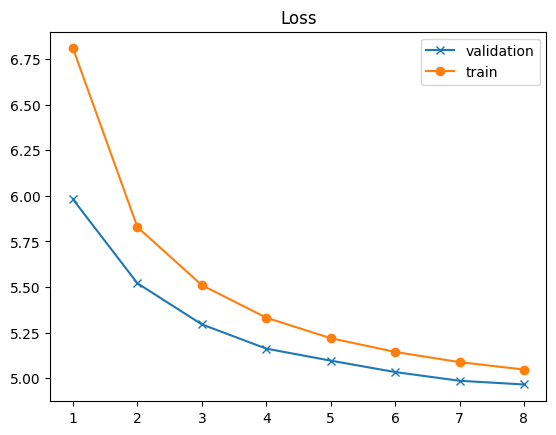

smallest val loss: (8, 4.964786)
Current Lr:  0.0009235856

Time taken for this epoch: 94.52 secs

Epoch 9 Batch 0 Loss 5.0425
Epoch 9 Batch 150 Loss 5.0002
Epoch 9 Batch 300 Loss 5.0049
Epoch 9 Batch 450 Loss 5.0062
Epoch 9 Batch 600 Loss 5.0083
Epoch 9 Batch 750 Loss 5.0128

german automaker volkswagen has unveiled a new electric car that will be the first electric car in the car the car will be used to be used to the car the car the car will be used to be used to the car the car will be used to be used to the car the car will be used to be used
a yearold woman who was arrested on monday in a case against the police in the case of the police have been arrested in the case of the case the case was found guilty of the case the case was found guilty of the case the case was found guilty of the case of the case was filed by the police
the election commission on wednesday announced that the election commission has been declared the ec to be held in the assembly elections in the state asse

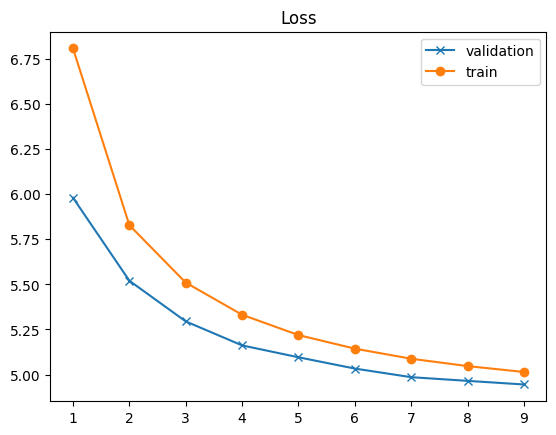

smallest val loss: (9, 4.9447093)
Current Lr:  0.0009144524

Time taken for this epoch: 96.40 secs

Epoch 10 Batch 0 Loss 4.8463
Epoch 10 Batch 150 Loss 4.9622
Epoch 10 Batch 300 Loss 4.9721
Epoch 10 Batch 450 Loss 4.9799
Epoch 10 Batch 600 Loss 4.9829
Epoch 10 Batch 750 Loss 4.9846

volkswagen has announced that the company will be the worlds first time to be the first time to be the company in the company said that the company is the first time of the company is expected to be the first time of the company the company said that the company will be the first time of the company
the police on thursday arrested the police of the police officers of the police have been arrested in connection with the police said the police said the police has been arrested in connection with the case of the police officers were arrested in connection with the police said the police had been arrested in connection with the police
the election commission on tuesday announced that the election commission ha

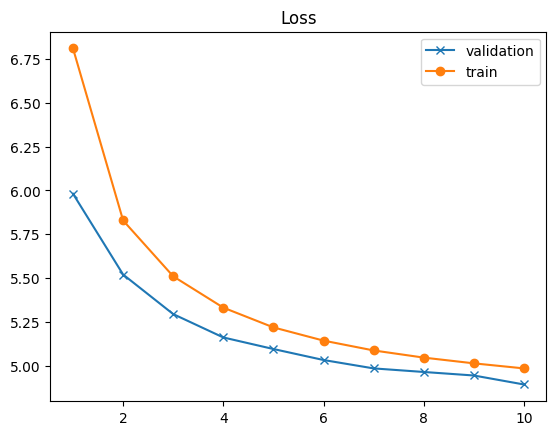

smallest val loss: (10, 4.8935056)
Current Lr:  0.0009054096

Time taken for this epoch: 95.86 secs

Epoch 11 Batch 0 Loss 4.9028
Epoch 11 Batch 150 Loss 4.9484
Epoch 11 Batch 300 Loss 4.9540
Epoch 11 Batch 450 Loss 4.9537
Epoch 11 Batch 600 Loss 4.9560
Epoch 11 Batch 750 Loss 4.9602

the <UNK> electric vehicle manufacturer <UNK> has been sued by the company of the company in the company has been sued by the company in the company has been sued by the company in the company had been sued by the company in the company had been sued by the company in the company
the delhi police on tuesday arrested a yearold woman in the delhi police station in the police said that the police have been arrested in the case of the police station in the case the police said the police has been arrested in the case of the police station in the case of the police
the election commission on tuesday said that the election commission has been taken to the election commission of the election commission of the st

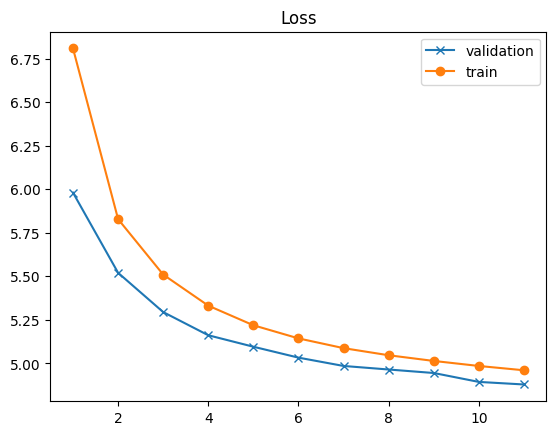

smallest val loss: (11, 4.8787866)
Current Lr:  0.00089645607

Time taken for this epoch: 94.16 secs

Epoch 12 Batch 0 Loss 4.9736
Epoch 12 Batch 150 Loss 4.9176
Epoch 12 Batch 300 Loss 4.9228
Epoch 12 Batch 450 Loss 4.9283
Epoch 12 Batch 600 Loss 4.9364
Epoch 12 Batch 750 Loss 4.9391

volkswagen has said that the company will be used to be used to build a <UNK> electric vehicle in the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> the company will be used to build a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> will be used in the <UNK> <UNK>
the delhi police on thursday arrested a complaint against the police of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder case the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder case was filed
the election commission on wednesday announced that the election commission will be held in the assembly election

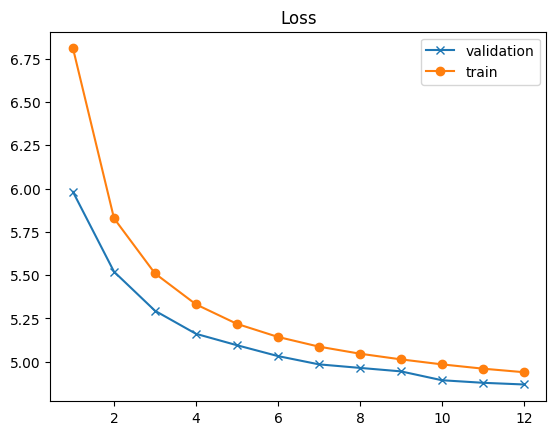

smallest val loss: (12, 4.869051)
Current Lr:  0.0008875911

Time taken for this epoch: 94.80 secs

Epoch 13 Batch 0 Loss 4.9383
Epoch 13 Batch 150 Loss 4.9034
Epoch 13 Batch 300 Loss 4.9101
Epoch 13 Batch 450 Loss 4.9137
Epoch 13 Batch 600 Loss 4.9159
Epoch 13 Batch 750 Loss 4.9205

the indian automaker motor maker teslas has said that the company will be able to make the cars in the car the car will be able to be able to make the cars in the car the car will be able to be able to be able to be able to be able to be able to be able to be able
the delhi police on tuesday arrested a yearold woman in the case of rape case against the rape case of rape case the case was filed by the police the police said that the police has been arrested in the case of the case was filed by the police in the case of the case was filed by the police
the election commission on wednesday announced that the election commission will be held in the state assembly elections in the state assembly elections the e

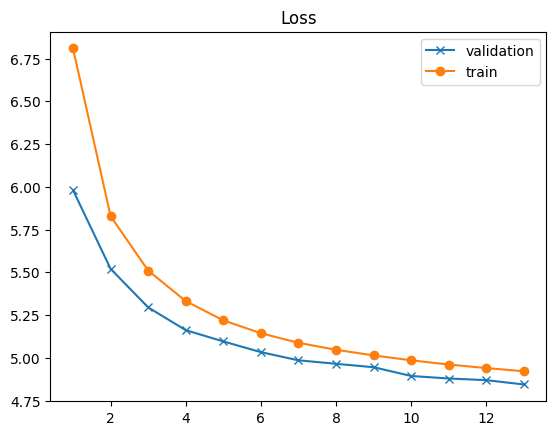

smallest val loss: (13, 4.8438334)
Current Lr:  0.0008788139

Time taken for this epoch: 96.07 secs

Epoch 14 Batch 0 Loss 4.7964
Epoch 14 Batch 150 Loss 4.8897
Epoch 14 Batch 300 Loss 4.8921
Epoch 14 Batch 450 Loss 4.8980
Epoch 14 Batch 600 Loss 4.9024
Epoch 14 Batch 750 Loss 4.9045

the <UNK> car manufacturer <UNK> has been named as the first <UNK> car in the <UNK> car the car will be used to be used to be used in the car the car will be used to be used to be used in the car the car will be used to be used to be used in the <UNK>
the delhi police on monday arrested a yearold woman in the delhi police said that the police has been arrested in connection with the alleged case of the police has been arrested in the case of the police said the police has been arrested in the case of the police and the police had arrested the police
the election commission on wednesday announced that the election commission of the state assembly elections in the state assembly elections the election commi

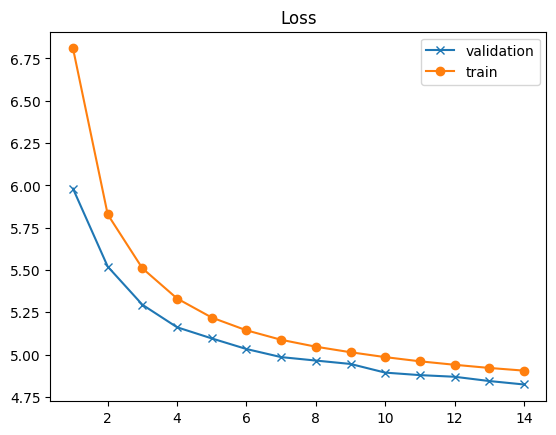

smallest val loss: (14, 4.823443)
Current Lr:  0.00087012345

Time taken for this epoch: 96.90 secs

Epoch 15 Batch 0 Loss 4.8419
Epoch 15 Batch 150 Loss 4.8739
Epoch 15 Batch 300 Loss 4.8773
Epoch 15 Batch 450 Loss 4.8782
Epoch 15 Batch 600 Loss 4.8854
Epoch 15 Batch 750 Loss 4.8893

the <UNK> electric manufacturer has been appointed as the first of the <UNK> electric car in the us the company has been named as the first electric car in the car the car will be available in the car the car will be available in the car the car will be available in the <UNK>
the delhi police on tuesday arrested the police of the police on the alleged case of the police on the pretext of the murder case the case was filed by the police in the case the case was filed by the police in the case the case was filed by the police in the case
the election commission on wednesday announced that the election commission of the election commission of the constituencies in the constituencies in the state assembly ele

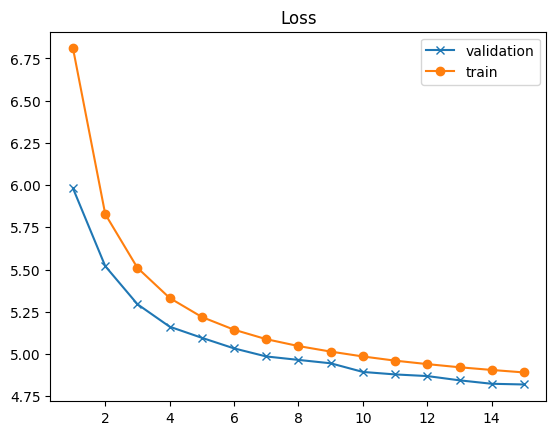

smallest val loss: (15, 4.8192587)
Current Lr:  0.0008615189

Time taken for this epoch: 95.68 secs

Epoch 16 Batch 0 Loss 4.8873
Epoch 16 Batch 150 Loss 4.8612
Epoch 16 Batch 300 Loss 4.8621
Epoch 16 Batch 450 Loss 4.8693
Epoch 16 Batch 600 Loss 4.8727
Epoch 16 Batch 750 Loss 4.8763

german automaker volkswagen has announced that the company will be able to make the first time to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be used
the delhi police has filed a complaint against the rape case of rape harassment against the police in the case of the police said the police has been arrested in connection with the case of the police said the police said the police has been arrested in connection with the police said the police said
the election commission on wednesday announced that the election commission has been released the election commission for the assembly elections in the 

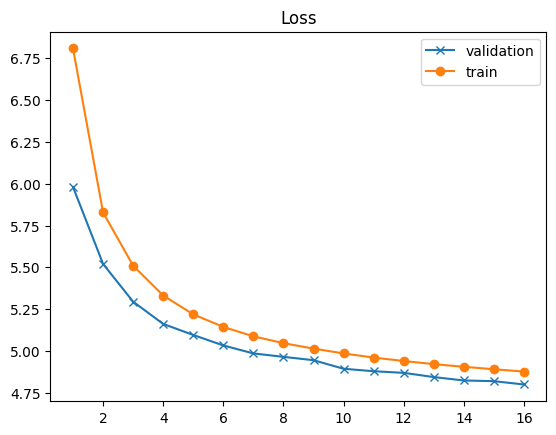

smallest val loss: (16, 4.79951)
Current Lr:  0.0008529995

Time taken for this epoch: 95.72 secs

Epoch 17 Batch 0 Loss 4.6953
Epoch 17 Batch 150 Loss 4.8444
Epoch 17 Batch 300 Loss 4.8487
Epoch 17 Batch 450 Loss 4.8552
Epoch 17 Batch 600 Loss 4.8608
Epoch 17 Batch 750 Loss 4.8660

the indian automobile manufacturer <UNK> has been appointed as the first indian automobile manufacturer in the country the company will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to
the police on thursday arrested the police of the police on the alleged rape case of rape case against the police in the case of the police has been arrested by the police in the case the case was filed by the police in the case the case was filed by the police
the election commission has released a voter turnout of the election commission of the election commission on friday said the election commission has also sought a 

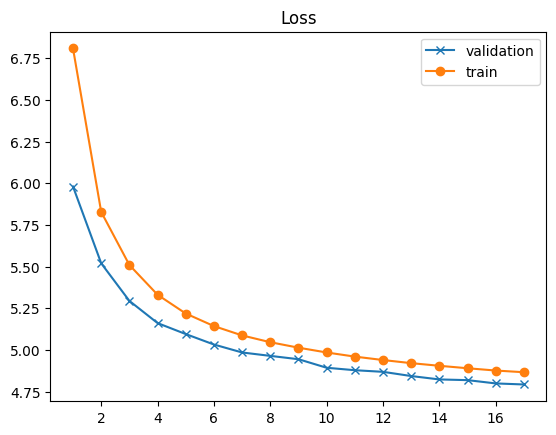

smallest val loss: (17, 4.793207)
Current Lr:  0.00084456423

Time taken for this epoch: 97.37 secs

Epoch 18 Batch 0 Loss 4.9381
Epoch 18 Batch 150 Loss 4.8355
Epoch 18 Batch 300 Loss 4.8393
Epoch 18 Batch 450 Loss 4.8483
Epoch 18 Batch 600 Loss 4.8513
Epoch 18 Batch 750 Loss 4.8556

german automaker volkswagen has announced that the company will be the worlds first electric car in the car will be used to be used in the car the car will be used to be used in the car the car will be used to be used in the car will be used to be used in the car
a yearold woman who was arrested on thursday in a complaint against the police in the case of rape case against the police on friday the accused was arrested in the case of rape case the case was filed by the police in the case of the police said the police has been arrested in the case
the election commission on thursday announced that the election commission of the election commission of the election commission of the election commission has al

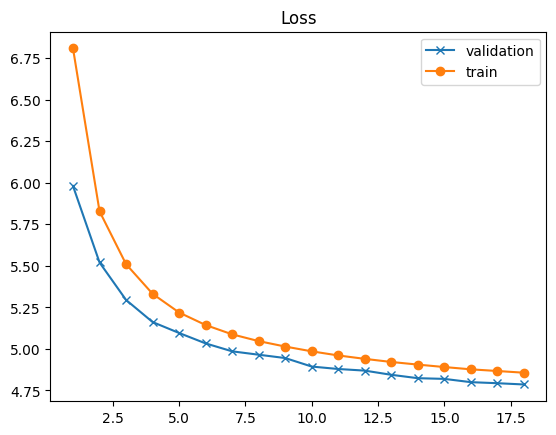

smallest val loss: (18, 4.785594)
Current Lr:  0.0008362125

Time taken for this epoch: 98.42 secs

Epoch 19 Batch 0 Loss 4.7241
Epoch 19 Batch 150 Loss 4.8222
Epoch 19 Batch 300 Loss 4.8339
Epoch 19 Batch 450 Loss 4.8370
Epoch 19 Batch 600 Loss 4.8402
Epoch 19 Batch 750 Loss 4.8449

german automaker volkswagen has announced that the company will be the first time to be the first time to be the first time the company will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be used to be used in
the delhi police on tuesday arrested the police of the police on charges of rape case against the alleged rape case of rape case against the police said the police has been arrested in connection with the case of rape case the case was filed by the police said the police had been arrested in connection with the case
the election commission on tuesday announced that the election commission will be held in the state assembly elections in th

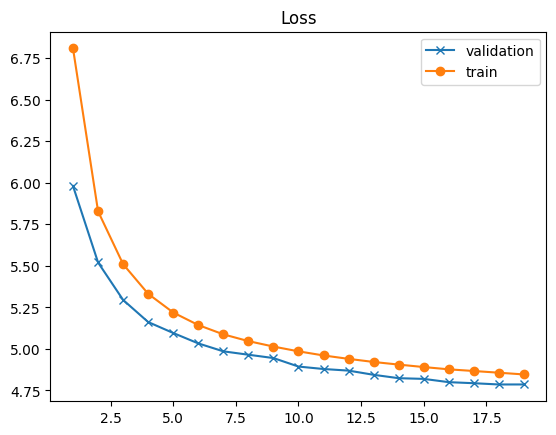

smallest val loss: (18, 4.785594)
Current Lr:  0.0008279433

Time taken for this epoch: 97.72 secs

Epoch 20 Batch 0 Loss 4.9063
Epoch 20 Batch 150 Loss 4.8209
Epoch 20 Batch 300 Loss 4.8285
Epoch 20 Batch 450 Loss 4.8290
Epoch 20 Batch 600 Loss 4.8341
Epoch 20 Batch 750 Loss 4.8371

the indian automaker of the indian automobile manufacturer <UNK> has announced that the company will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be used in the company said the company said
the delhi police on thursday arrested the police of the police on thursday after the police complaint against the police in connection with the alleged that the police has been arrested by the police station police said the police said the police has been arrested by the police to the police station the police said the police said
the election commission on wednesday announced that the election commission of the state assembly polls 

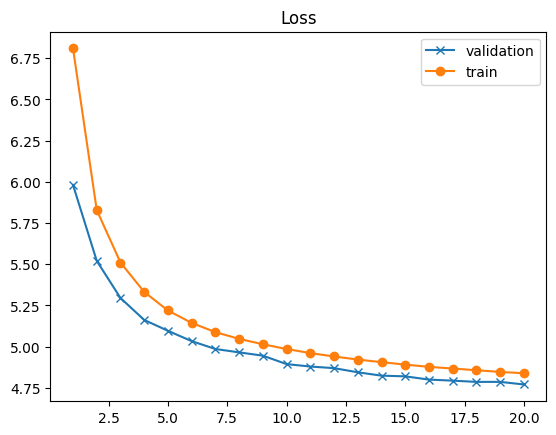

smallest val loss: (20, 4.7699475)
Current Lr:  0.0008197559

Time taken for this epoch: 97.33 secs

Epoch 21 Batch 0 Loss 4.7073
Epoch 21 Batch 150 Loss 4.8091
Epoch 21 Batch 300 Loss 4.8156
Epoch 21 Batch 450 Loss 4.8203
Epoch 21 Batch 600 Loss 4.8239
Epoch 21 Batch 750 Loss 4.8292

german automaker ford has appointed the first batch of the <UNK> car car car the car will be used to be used in the <UNK> car the car will be available in the car the car will be available in the car the car will be available in the car the car will be available in the <UNK>
a delhi court on thursday filed a complaint against the rape case of rape case against the rape case of rape case against the rape case of rape case against the case of rape case against the case of rape case the case was registered against the case of rape case against the case of rape case in the case
the election commission on wednesday announced that the election commission has been the most of the state assembly elections in the 

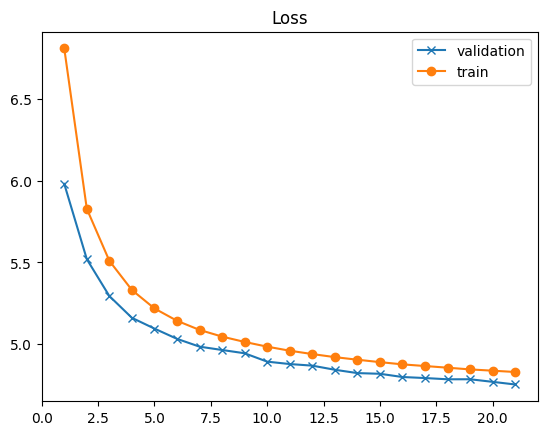

smallest val loss: (21, 4.753835)
Current Lr:  0.0008116494

Time taken for this epoch: 96.44 secs

Epoch 22 Batch 0 Loss 4.7862
Epoch 22 Batch 150 Loss 4.7977
Epoch 22 Batch 300 Loss 4.8037
Epoch 22 Batch 450 Loss 4.8107
Epoch 22 Batch 600 Loss 4.8151
Epoch 22 Batch 750 Loss 4.8212

german automaker volkswagen has announced that the company will be the first time to be the first time to be the first time to be the first time in the company will be the first time to be the first time in the company will be the first time to be the first time in the company
the delhi police on wednesday arrested the police in connection with the murder of rape case in the case of rape case the accused of raping the accused of raping the accused of raping the accused of raping the accused of raping the accused of raping the accused of raping the accused of raping the accused of raping the accused of raping
the election commission on wednesday announced that the election commission has been declared in th

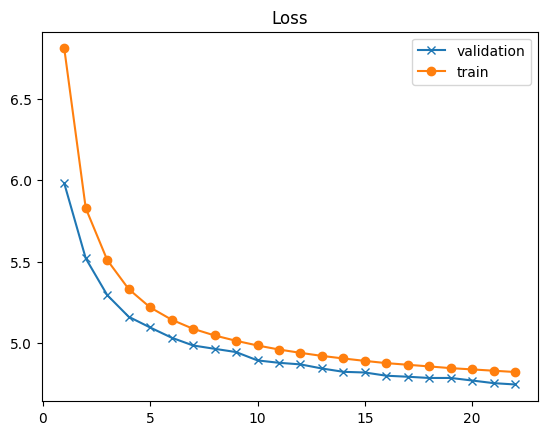

smallest val loss: (22, 4.7456837)
Current Lr:  0.0008036231

Time taken for this epoch: 95.42 secs

Epoch 23 Batch 0 Loss 4.8385
Epoch 23 Batch 150 Loss 4.7893
Epoch 23 Batch 300 Loss 4.8023
Epoch 23 Batch 450 Loss 4.8067
Epoch 23 Batch 600 Loss 4.8098
Epoch 23 Batch 750 Loss 4.8145

german automaker volkswagen has announced that the company of the company of the company of the company will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be <UNK>
the delhi police on monday arrested the police in connection with the alleged rape case of rape in the case of rape case the case was filed by the police in connection with the case of the case of the case was filed by the police in connection with the case of the case was filed by the police
the election commission on wednesday announced that the election commission of the election commission of the state assembly elections the election 

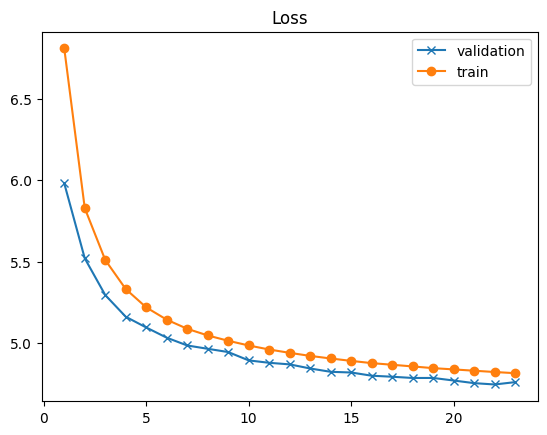

smallest val loss: (22, 4.7456837)
Current Lr:  0.0007956762

Time taken for this epoch: 97.84 secs

Epoch 24 Batch 0 Loss 4.7305
Epoch 24 Batch 150 Loss 4.7858
Epoch 24 Batch 300 Loss 4.7900
Epoch 24 Batch 450 Loss 4.7989
Epoch 24 Batch 600 Loss 4.8015
Epoch 24 Batch 750 Loss 4.8074

the us motor manufacturer ford has announced that the company will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be used in the <UNK>
the delhi police on wednesday arrested the police for allegedly raping a woman who was arrested in connection with the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the woman who was arrested in
the election commission on wednesday announced that the election commission has been the second phase of the state assembly elections in the state assembly ele

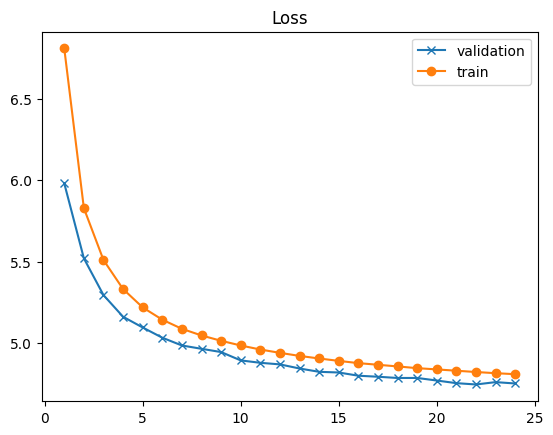

smallest val loss: (22, 4.7456837)
Current Lr:  0.0007878079

Time taken for this epoch: 98.26 secs

Epoch 25 Batch 0 Loss 4.8499
Epoch 25 Batch 150 Loss 4.7766
Epoch 25 Batch 300 Loss 4.7896
Epoch 25 Batch 450 Loss 4.7934
Epoch 25 Batch 600 Loss 4.7968
Epoch 25 Batch 750 Loss 4.8011

german automaker volkswagen has announced that the company will be able to make the cars in the cars in the next three months the company will be able to make the cars in the cars the car the car will be available in the car the car will be available in the car the car will be available in
the police on thursday arrested the police of the police in connection with the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the
the election commission on wednesday announced that the election commission of the state assembly elections in the stat

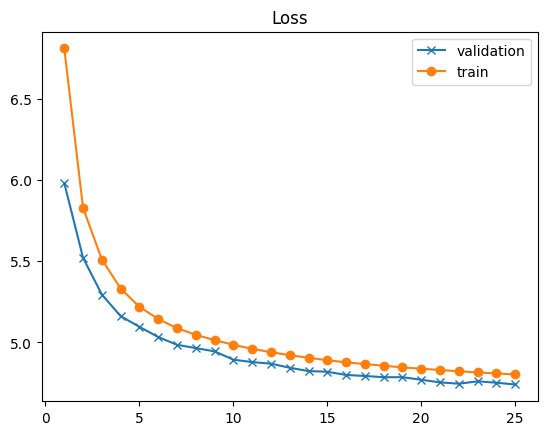

smallest val loss: (25, 4.740892)
Current Lr:  0.0007800174

Time taken for this epoch: 97.91 secs

Epoch 26 Batch 0 Loss 4.8421
Epoch 26 Batch 150 Loss 4.7731
Epoch 26 Batch 300 Loss 4.7825
Epoch 26 Batch 450 Loss 4.7850
Epoch 26 Batch 600 Loss 4.7877
Epoch 26 Batch 750 Loss 4.7947

the <UNK> automaker has announced that it will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to
a yearold woman has been arrested in the case of rape case against the rape case of the rape case was registered against the police in the case of the accused of raping her husband and her husband of raping her husband and her husband and her husband and her husband were arrested in the police said
the election commission on wednesday announced that the poll poll booths in the election commission has been declared in the election commission for the election commissi

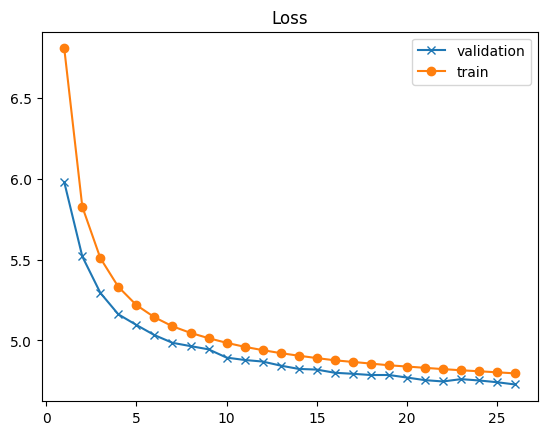

smallest val loss: (26, 4.7270083)
Current Lr:  0.0007723039

Time taken for this epoch: 95.73 secs

Epoch 27 Batch 0 Loss 4.7242
Epoch 27 Batch 150 Loss 4.7697
Epoch 27 Batch 300 Loss 4.7756
Epoch 27 Batch 450 Loss 4.7802
Epoch 27 Batch 600 Loss 4.7843
Epoch 27 Batch 750 Loss 4.7901

the <UNK> company has announced that the company will be able to use a selfdriving car to be used to <UNK> cars the company will be able to be able to be able to be able to be able to be used to be used in the car the car will be available in the <UNK>
a yearold woman was arrested in a complaint against the rape case of rape case on monday the police said the police has arrested the police in connection with the murder of rape case the police said the police has been arrested in connection with the murder of the murder of the murder of the murder of the murder of the murder
the west bengal assembly on wednesday announced that the election commission of the state assembly polls in the state assembly polls 

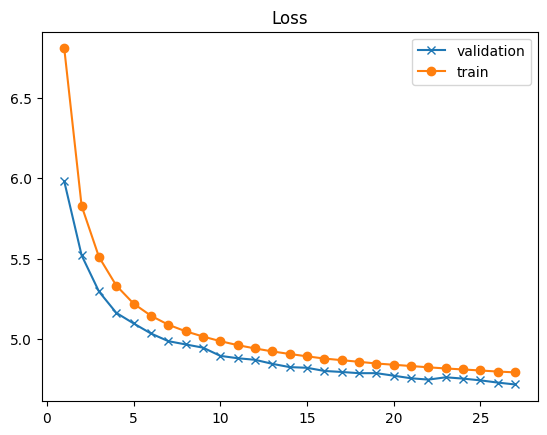

smallest val loss: (27, 4.715279)
Current Lr:  0.0007646667

Time taken for this epoch: 94.71 secs

Epoch 28 Batch 0 Loss 4.8422
Epoch 28 Batch 150 Loss 4.7610
Epoch 28 Batch 300 Loss 4.7686
Epoch 28 Batch 450 Loss 4.7729
Epoch 28 Batch 600 Loss 4.7779
Epoch 28 Batch 750 Loss 4.7841

the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> has been appointed as the first automaker of the <UNK> car in the upcoming <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
a yearold woman was arrested on saturday in connection with the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the
the election commission on thursday announced that the poll poll in the asse

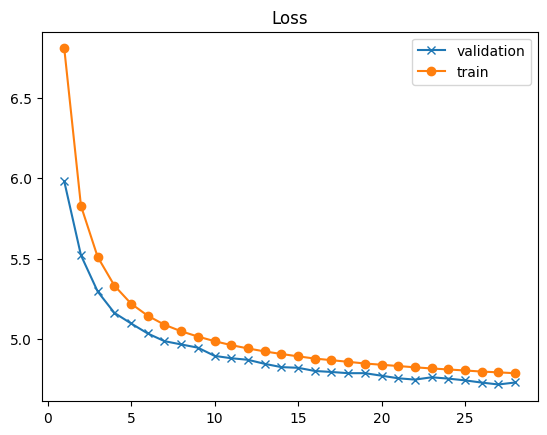

smallest val loss: (27, 4.715279)
Current Lr:  0.00075710495

Time taken for this epoch: 97.06 secs

Epoch 29 Batch 0 Loss 4.6447
Epoch 29 Batch 150 Loss 4.7529
Epoch 29 Batch 300 Loss 4.7603
Epoch 29 Batch 450 Loss 4.7665
Epoch 29 Batch 600 Loss 4.7735
Epoch 29 Batch 750 Loss 4.7796

german automobile manufacturer volkswagen has announced that the company of the cars of the cars of the cars will be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be
the delhi police on tuesday arrested the police have filed a complaint against the rape case of rape and rape in the case the case was filed by the police to probe the rape case the case was filed by the police to probe the rape case the case was filed by the police
the election commission on wednesday announced that the poll of the poll poll poll in the state assembly elections the poll poll poll the poll was held in the state assembly el

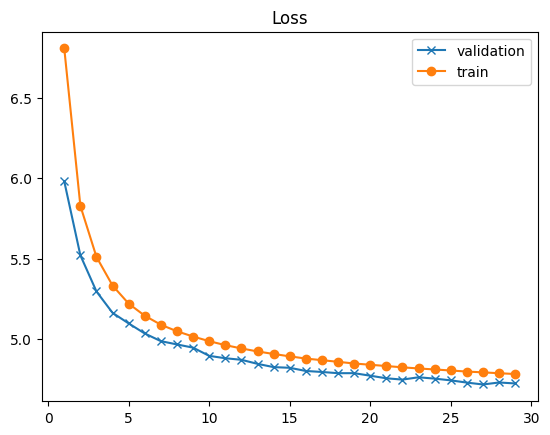

smallest val loss: (27, 4.715279)
Current Lr:  0.0007496181

Time taken for this epoch: 96.14 secs

Epoch 30 Batch 0 Loss 4.7391
Epoch 30 Batch 150 Loss 4.7506
Epoch 30 Batch 300 Loss 4.7594
Epoch 30 Batch 450 Loss 4.7629
Epoch 30 Batch 600 Loss 4.7685
Epoch 30 Batch 750 Loss 4.7751

the <UNK> electric car manufacturer <UNK> has developed a new <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
a yearold student in the uttar pradesh has been registered against the rape of rape of rape and rape in the case of rape and rape in the case was registered against the police said the police said the police has also been arrested in connection with the fir was registered in the case of the rape case
the election commission on wednesday announced that the election comm

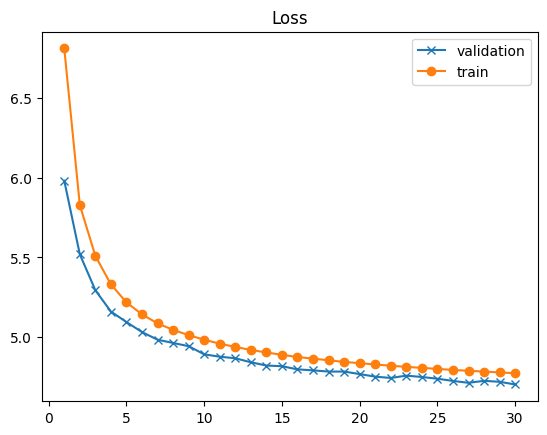

smallest val loss: (30, 4.704844)
Current Lr:  0.00074220524

Time taken for this epoch: 96.35 secs

Epoch 31 Batch 0 Loss 4.7261
Epoch 31 Batch 150 Loss 4.7454
Epoch 31 Batch 300 Loss 4.7533
Epoch 31 Batch 450 Loss 4.7569
Epoch 31 Batch 600 Loss 4.7645
Epoch 31 Batch 750 Loss 4.7700

the us government has decided to introduce a selfdriving <UNK> <UNK> <UNK> to <UNK> the car in the car which is a <UNK> car that can be used to be used to be used by the car the car will be available in the car the car will be available in the car the car will be available in the car
the delhi police on thursday registered a case against the police in connection with the alleged rape case of rape and rape in the case of the case was registered against the police in connection with the case of the case the case was registered against the police in the case of the case of the case was registered in
the west bengal assembly on wednesday declared the election commission of the state assembly elections in the 

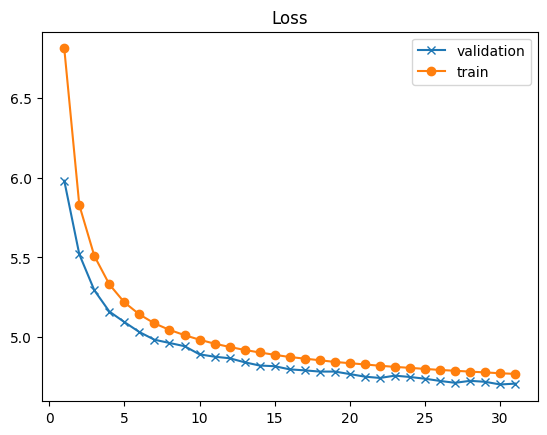

smallest val loss: (30, 4.704844)
Current Lr:  0.00073486567

Time taken for this epoch: 97.88 secs

Epoch 32 Batch 0 Loss 4.7474
Epoch 32 Batch 150 Loss 4.7425
Epoch 32 Batch 300 Loss 4.7451
Epoch 32 Batch 450 Loss 4.7554
Epoch 32 Batch 600 Loss 4.7614
Epoch 32 Batch 750 Loss 4.7661

the <UNK> car manufacturer ford has been named as the first car driver of the car the car is a <UNK> car in the car the car is a <UNK> car the car is a <UNK> car and a car the car is a <UNK> car and a car the car is a <UNK> car
a yearold woman was registered against a yearold girl in the case of rape case on wednesday the woman was registered against her husband and her husband <UNK> <UNK> <UNK> who was arrested in the case of her husband and her husband was arrested in the case of her husband and her husband was arrested in the case
the election commission on wednesday announced that the poll of the state assembly elections in the state assembly elections the poll was recorded by the ec and the ec of the

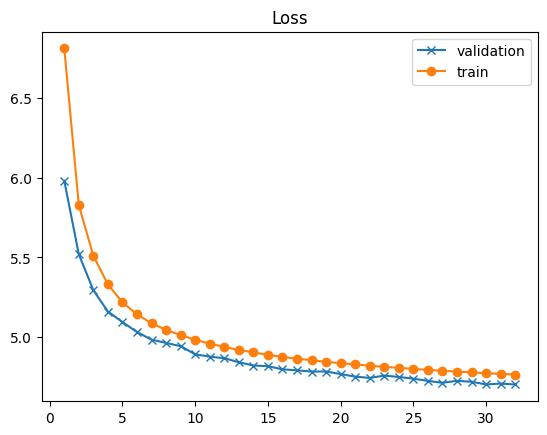

smallest val loss: (32, 4.704648)
Current Lr:  0.00072759873

Time taken for this epoch: 94.98 secs

Epoch 33 Batch 0 Loss 4.7353
Epoch 33 Batch 150 Loss 4.7358
Epoch 33 Batch 300 Loss 4.7456
Epoch 33 Batch 450 Loss 4.7506
Epoch 33 Batch 600 Loss 4.7570
Epoch 33 Batch 750 Loss 4.7615

the <UNK> electric car manufacturer ford has developed a selfdriving <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK>
a yearold woman was booked by a woman in the disproportionate rape case against her husband and her husband of her husband and her husband was arrested on monday the woman was arrested by the police in the police said the woman was on the case of rape and murder of rape and murder of the woman was reportedly raped by her
the election commission on tuesday a

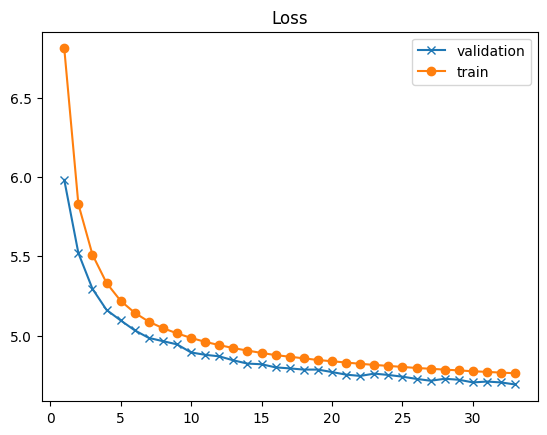

smallest val loss: (33, 4.691796)
Current Lr:  0.00072040356

Time taken for this epoch: 98.49 secs

Epoch 34 Batch 0 Loss 4.6289
Epoch 34 Batch 150 Loss 4.7314
Epoch 34 Batch 300 Loss 4.7438
Epoch 34 Batch 450 Loss 4.7467
Epoch 34 Batch 600 Loss 4.7511
Epoch 34 Batch 750 Loss 4.7577

the indian automaker has created a <UNK> car that can be used to <UNK> cars in the car the car will be used to be used to be used to be used to be used to be used to <UNK> the car the car will be used to be used to be used to be used to <UNK> the car
a yearold woman has been registered against the yearold woman in the case of the rape case in the case of the yearold <UNK> <UNK> was filed by the police on monday the accused were arrested in connection with the case of the accused of raping her and raped her and her husband and her husband were arrested in the case
the election commission on wednesday announced that the election commission has been declared in the state for the first phase of the assembly e

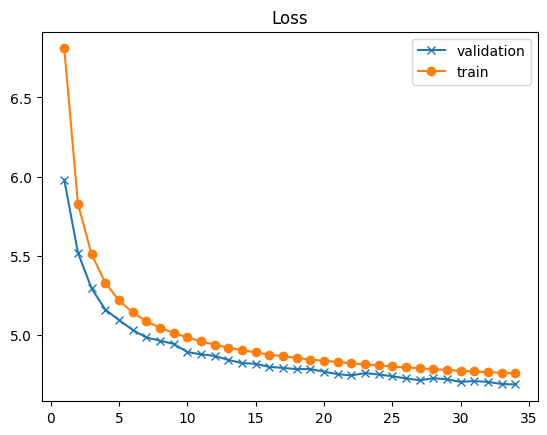

smallest val loss: (34, 4.688526)
Current Lr:  0.0007132796

Time taken for this epoch: 98.60 secs

Epoch 35 Batch 0 Loss 4.6598
Epoch 35 Batch 150 Loss 4.7309
Epoch 35 Batch 300 Loss 4.7378
Epoch 35 Batch 450 Loss 4.7444
Epoch 35 Batch 600 Loss 4.7468
Epoch 35 Batch 750 Loss 4.7530

the new <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> has created a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK>
a delhi court on thursday filed a complaint against the police in connection with the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder
the election commission on thursday announced that the poll turnout of the

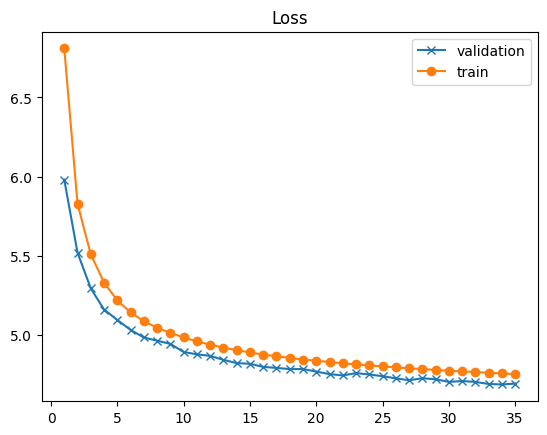

smallest val loss: (34, 4.688526)
Current Lr:  0.0007062261

Time taken for this epoch: 96.84 secs

Epoch 36 Batch 0 Loss 4.6558
Epoch 36 Batch 150 Loss 4.7142
Epoch 36 Batch 300 Loss 4.7281
Epoch 36 Batch 450 Loss 4.7376
Epoch 36 Batch 600 Loss 4.7426
Epoch 36 Batch 750 Loss 4.7503

the new technology firm <UNK> has created a <UNK> car that will be used to <UNK> cars in the cars the car will be used to be used by the car the car will be used to be used by the car the car will be used to be used by the car and will be used by the car
the delhi court on friday registered a case against the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder
the election commission on friday announced that the election commission has been declared the highest number of candidates in the state assembly elections the

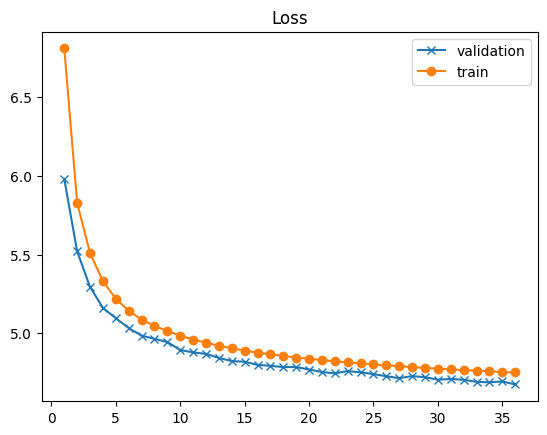

smallest val loss: (36, 4.6748695)
Current Lr:  0.0006992423

Time taken for this epoch: 98.26 secs

Epoch 37 Batch 0 Loss 4.6394
Epoch 37 Batch 150 Loss 4.7202
Epoch 37 Batch 300 Loss 4.7309
Epoch 37 Batch 450 Loss 4.7338
Epoch 37 Batch 600 Loss 4.7408
Epoch 37 Batch 750 Loss 4.7464

the <UNK> motor company has developed a <UNK> car that will be used to be used to be used in the cars the car will be used to be used to be used to be used in the car the car will be available in the car will be available in the car will be available in the <UNK>
a yearold woman has been filed against the murder of rape against the murder of rape against the murder of rape and murder of rape against the murder of rape the yearold was arrested by the police the police said on monday the police said the police has been arrested in connection with the murder of the murder
the election commission on wednesday announced that the voter turnout of the voter turnout of the voter turnout of the voter turnout of th

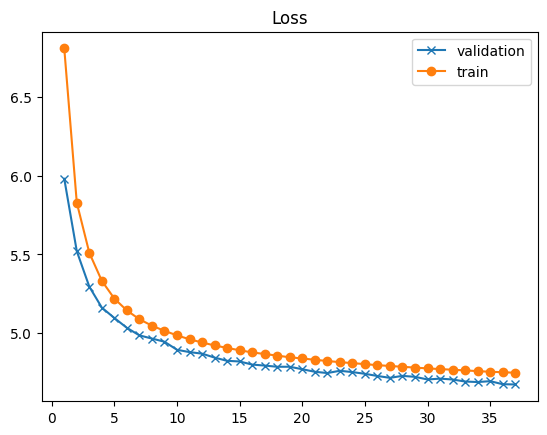

smallest val loss: (37, 4.6730127)
Current Lr:  0.00069232757

Time taken for this epoch: 98.90 secs

Epoch 38 Batch 0 Loss 4.5898
Epoch 38 Batch 150 Loss 4.7226
Epoch 38 Batch 300 Loss 4.7311
Epoch 38 Batch 450 Loss 4.7363
Epoch 38 Batch 600 Loss 4.7392
Epoch 38 Batch 750 Loss 4.7436

the new <UNK> car manufacturer <UNK> has been made by the formula of the car the car will be used to be used to be used to be used to be used to be used by the car the car will be used to be used to be used to be used by the car the car will be used to be
a yearold woman has been registered against the rape case of rape in the case of rape case of rape in the case of rape case the rape case was registered against the rape case was registered by the police on wednesday the police said the police said the police has also arrested the police in connection with the police
the election commission on friday announced that the election commission has been declared the highest number of candidates in the state a

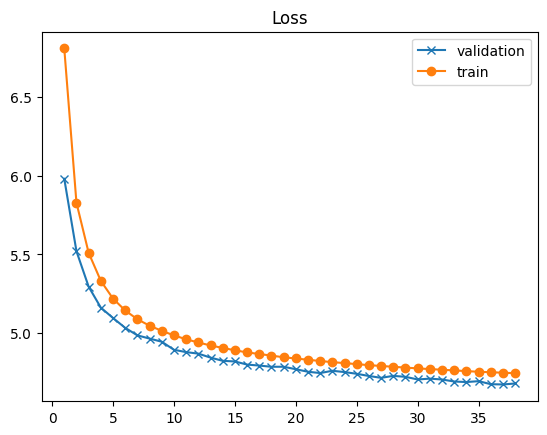

smallest val loss: (37, 4.6730127)
Current Lr:  0.0006854813

Time taken for this epoch: 99.40 secs

Epoch 39 Batch 0 Loss 4.6500
Epoch 39 Batch 150 Loss 4.7161
Epoch 39 Batch 300 Loss 4.7221
Epoch 39 Batch 450 Loss 4.7262
Epoch 39 Batch 600 Loss 4.7342
Epoch 39 Batch 750 Loss 4.7397

the indian automobile manufacturer <UNK> has developed a <UNK> car that can be used to fly the cars in the car the car will be used to be used to fly the car the car will be available in the car the car will be available in the car the car will be available in the car
the police on thursday registered a complaint against the police in the case of the rape case of the rape case of the rape case was registered against the police in the case the case was registered against the police the police said the police said the police has also filed a complaint against the police
the election commission on wednesday announced that the poll turnout of the polling in the state assembly elections the poll was recorded b

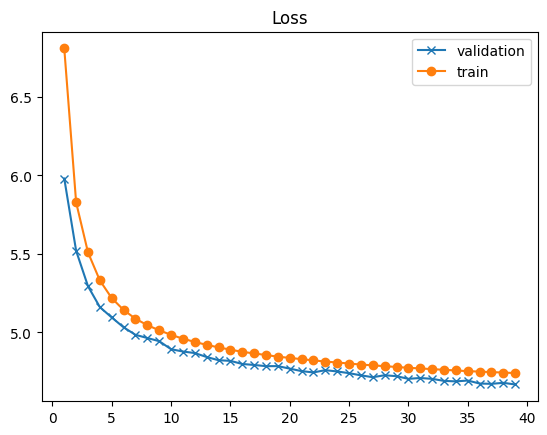

smallest val loss: (39, 4.6688876)
Current Lr:  0.0006787026

Time taken for this epoch: 96.72 secs

Epoch 40 Batch 0 Loss 4.7742
Epoch 40 Batch 150 Loss 4.7189
Epoch 40 Batch 300 Loss 4.7214
Epoch 40 Batch 450 Loss 4.7263
Epoch 40 Batch 600 Loss 4.7315
Epoch 40 Batch 750 Loss 4.7369

the new new new <UNK> motor manufacturer <UNK> has developed a new car that can be used to be used to be used in the car the car is expected to be used to be used to be used by the car the car is expected to be used to be used in the car
the delhi police on monday filed a complaint against the rape case against the rape case of rape case against the rape case of rape and rape and rape the court had filed a complaint against the fir against the court the court also filed a complaint against the fir against the court on the court
the election commission on wednesday announced that the election commission has been declared in the state assembly elections in the state the election commission has said that the

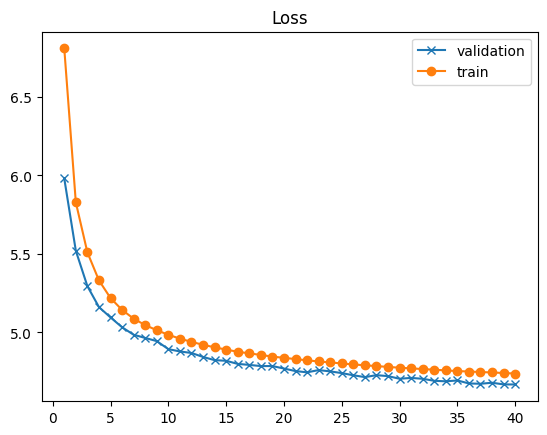

smallest val loss: (40, 4.668379)
Current Lr:  0.00067199103

Time taken for this epoch: 97.63 secs

Epoch 41 Batch 0 Loss 4.8070
Epoch 41 Batch 150 Loss 4.7158
Epoch 41 Batch 300 Loss 4.7156
Epoch 41 Batch 450 Loss 4.7225
Epoch 41 Batch 600 Loss 4.7290
Epoch 41 Batch 750 Loss 4.7343

the new <UNK> motor manufacturer <UNK> has developed a <UNK> car that can be used to make the car the car the car will be used to be used to <UNK> cars the car will be used to be used to <UNK> cars and <UNK> cars the car will be used to be used to be used by the company
a yearold woman from uttar pradesh has been registered against the rape of rape in the rape case of the rape case the woman who was arrested in the case of the rape case the woman had been registered in the case of the woman who was arrested in the case of the woman who was arrested in the case
the election commission on wednesday announced that the election commission will be the first time in the state assembly elections in the state ass

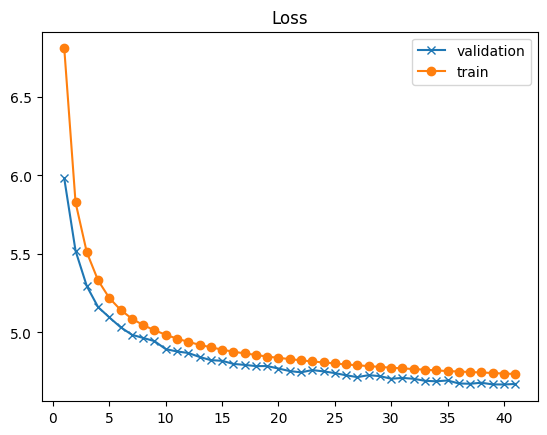

smallest val loss: (40, 4.668379)
Current Lr:  0.0006653458

Time taken for this epoch: 99.85 secs

Epoch 42 Batch 0 Loss 4.7183
Epoch 42 Batch 150 Loss 4.6988
Epoch 42 Batch 300 Loss 4.7108
Epoch 42 Batch 450 Loss 4.7221
Epoch 42 Batch 600 Loss 4.7249
Epoch 42 Batch 750 Loss 4.7307

the new technology company has developed a new <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK>
a yearold court on tuesday filed a complaint against the rape case against the murder of rape rape and rape in the case of rape case the case was filed against the case of rape case the case was filed by the court on friday the court said that the court has been hearing a complaint against the court
the election commission on friday announced that the election commission ha

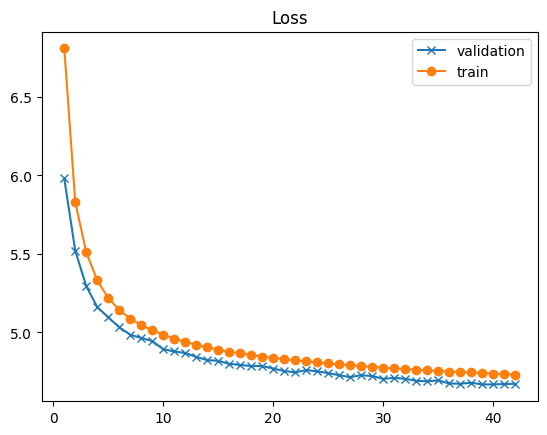

smallest val loss: (40, 4.668379)
Current Lr:  0.0006587663

Time taken for this epoch: 135.02 secs

Epoch 43 Batch 0 Loss 4.6513
Epoch 43 Batch 150 Loss 4.6988
Epoch 43 Batch 300 Loss 4.7056
Epoch 43 Batch 450 Loss 4.7149
Epoch 43 Batch 600 Loss 4.7204
Epoch 43 Batch 750 Loss 4.7277

the current <UNK> car manufacturer <UNK> has developed a <UNK> car that will be used to replace the car to be used to be used to be used to be used to <UNK> cars the car will be used to be used to be used to be used to be used by the car the car will be used to be used
the delhi police on wednesday filed a complaint against the rape case of rape in the case of rape case of rape in the case of rape case the case was filed by the police in the case the case was filed by the police on the complaint filed by the police on the complaint filed by the police
the election commission on wednesday announced that the election commission will be held in the state assembly elections in the state the election commissio

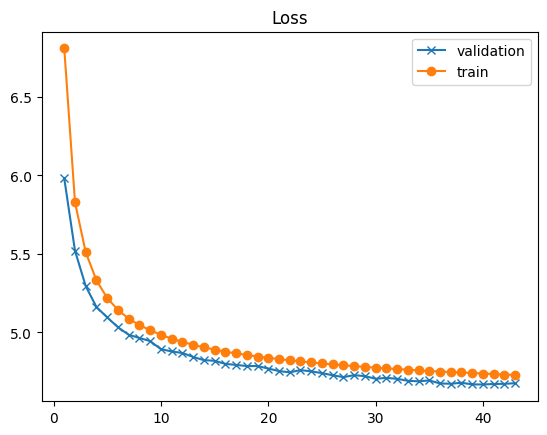

smallest val loss: (40, 4.668379)
Current Lr:  0.0006522519

Time taken for this epoch: 97.27 secs

Epoch 44 Batch 0 Loss 4.6675
Epoch 44 Batch 150 Loss 4.7038
Epoch 44 Batch 300 Loss 4.7107
Epoch 44 Batch 450 Loss 4.7131
Epoch 44 Batch 600 Loss 4.7192
Epoch 44 Batch 750 Loss 4.7260

ford motors has developed a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> to <UNK> cars in the car will be used to be used to be used to be used to be used by the company <UNK> and <UNK> <UNK> the company will be able to provide a <UNK> to the car to the car
a yearold woman has been booked for allegedly raping her with her husband and her husband <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> was booked for allegedly molesting her with her husband and her husband <UNK> <UNK> <UNK> <UNK> was also booked for a woman in the case the woman had been filed against her husband and her husband
the west bengal assembly on wednesday announced that the election commission will be the first time in the state assembly elections in th

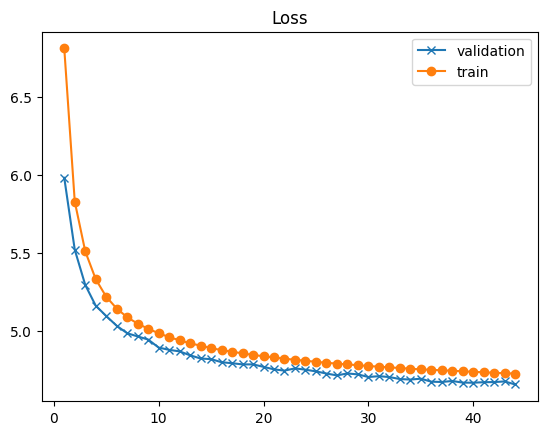

smallest val loss: (44, 4.657011)
Current Lr:  0.00064580183

Time taken for this epoch: 93.13 secs

Epoch 45 Batch 0 Loss 4.7449
Epoch 45 Batch 150 Loss 4.6915
Epoch 45 Batch 300 Loss 4.7081
Epoch 45 Batch 450 Loss 4.7119
Epoch 45 Batch 600 Loss 4.7181
Epoch 45 Batch 750 Loss 4.7239

the us government has introduced a new car to be used to <UNK> cars to be used to be <UNK> cars in the car the car is expected to be <UNK> to be used to be <UNK> cars the car will be used to be used to be used to be used to be used by the car
a yearold girl has been filed against the police in the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the murder of the
the west bengal assembly on thursday announced that the election commission will be the first time in the state assembly polls in the state the election commission has also anno

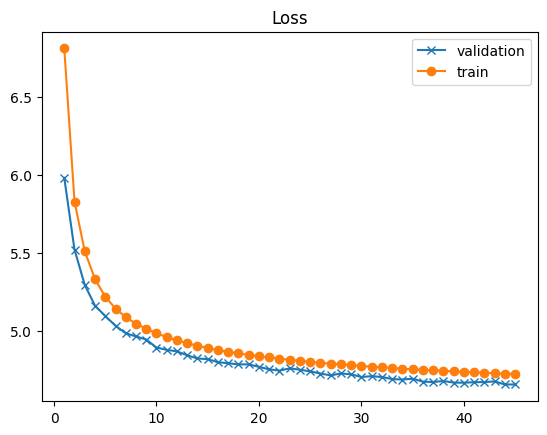

smallest val loss: (44, 4.657011)
Current Lr:  0.0006394156

Time taken for this epoch: 96.87 secs

Epoch 46 Batch 0 Loss 4.7002
Epoch 46 Batch 150 Loss 4.6886
Epoch 46 Batch 300 Loss 4.7065
Epoch 46 Batch 450 Loss 4.7099
Epoch 46 Batch 600 Loss 4.7159
Epoch 46 Batch 750 Loss 4.7201

the new new <UNK> car manufacturer <UNK> has created a new car that can be used to be used to be used by the car the car will be used to be used to be used by the car the car will be used to be used to be used by the car the car will be available in the car
the police on friday registered a complaint against the rape case against the rape case of rape case the case was registered against the rape case the case was registered against the rape case the case was registered against the police in the case the case was registered against the police
the election commission on thursday announced that the voter turnout of the assembly elections in the state assembly elections were held in the state assembly electio

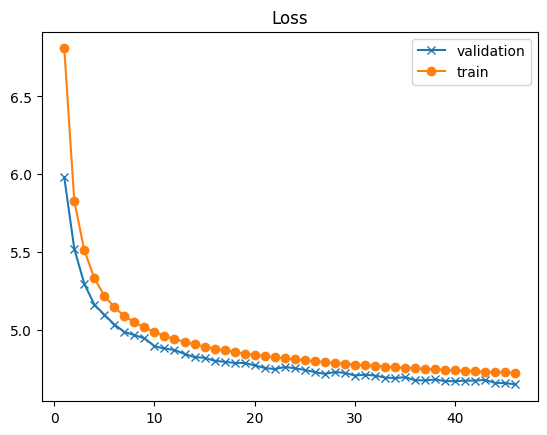

smallest val loss: (46, 4.6471868)
Current Lr:  0.0006330925

Time taken for this epoch: 95.77 secs

Epoch 47 Batch 0 Loss 4.7428
Epoch 47 Batch 150 Loss 4.6938
Epoch 47 Batch 300 Loss 4.7001
Epoch 47 Batch 450 Loss 4.7070
Epoch 47 Batch 600 Loss 4.7135
Epoch 47 Batch 750 Loss 4.7188

the new new <UNK> <UNK> <UNK> <UNK> has been introduced by the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK>
a yearold woman has been registered against a yearold woman in the uttar pradesh assembly on wednesday the fir was registered by the police on the pretext of the rape of rape and rape the police said the police the police said the police has been arrested in connection with the fir against the police
the west bengal assembly on wednesday declared the number of candidates in the state assembly

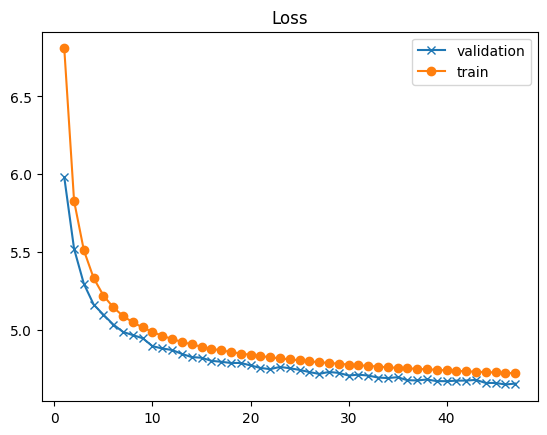

smallest val loss: (46, 4.6471868)
Current Lr:  0.0006268319

Time taken for this epoch: 94.82 secs

Epoch 48 Batch 0 Loss 4.5898
Epoch 48 Batch 150 Loss 4.6890
Epoch 48 Batch 300 Loss 4.7000
Epoch 48 Batch 450 Loss 4.7083
Epoch 48 Batch 600 Loss 4.7139
Epoch 48 Batch 750 Loss 4.7166

the us government has introduced a selfdriving <UNK> <UNK> <UNK> <UNK> <UNK> to conduct the selfdriving car in the us the team of the car will be able to be able to be able to be able to be able to be able to use the car the car will be used to be used to the car
a yearold woman has been registered against the rape case in the case of rape case in the case of rape case the police said on friday the police said the police said the police has been arrested in connection with the case of the victim the victim was filed against the police in the case
the west bengal assembly on wednesday declared the first time of the assembly elections in west bengal the state assembly elections the election commission has s

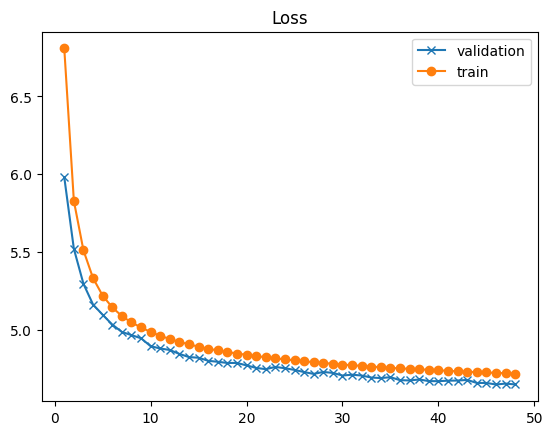

smallest val loss: (46, 4.6471868)
Current Lr:  0.00062063325

Time taken for this epoch: 95.53 secs

Epoch 49 Batch 0 Loss 4.7118
Epoch 49 Batch 150 Loss 4.6811
Epoch 49 Batch 300 Loss 4.6962
Epoch 49 Batch 450 Loss 4.6999
Epoch 49 Batch 600 Loss 4.7088
Epoch 49 Batch 750 Loss 4.7138

the new <UNK> electric car manufacturer <UNK> has created a <UNK> car that can be used to <UNK> cars to <UNK> cars the car will be used to be used to <UNK> cars the car will be used to be used to <UNK> cars the car will be used to be used by the car
a yearold girl was registered against a woman in the uttar pradesh on monday in connection with the rape case of rape in the case the case was registered against the girl in the case the case was registered in the case the case was registered in the case of rape case the case was registered in the case
the west bengal assembly on saturday announced that the election commission has been declared in the state assembly elections in the state the election commiss

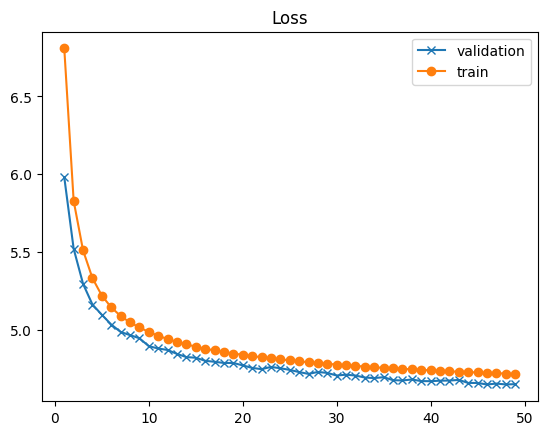

smallest val loss: (46, 4.6471868)
Current Lr:  0.0006144959

Time taken for this epoch: 93.70 secs

Epoch 50 Batch 0 Loss 4.7518
Epoch 50 Batch 150 Loss 4.6945
Epoch 50 Batch 300 Loss 4.6941
Epoch 50 Batch 450 Loss 4.6987
Epoch 50 Batch 600 Loss 4.7028
Epoch 50 Batch 750 Loss 4.7106

the new <UNK> car manufacturer <UNK> has introduced a new car that will be used to be used by the company the company has been able to use the car the car will be used to be used by the car the car will be used to be used to be used by the company
a yearold woman has been registered against a yearold woman in the case of rape against the rape of rape in the case of rape case the woman was registered against the police said the police said the police has also asked the police to file a complaint against the police in the case of the police
the west bengal assembly on saturday announced that the election commission has been declared in the state assembly elections in the state assembly elections the poll wa

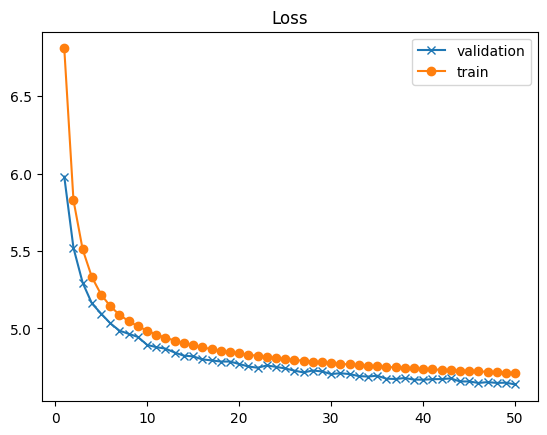

smallest val loss: (50, 4.6374493)
Current Lr:  0.00060841924

Time taken for this epoch: 95.45 secs



In [54]:
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):

        train_step(inp, tar)

        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))

    print()
    print(summarize(clean_words(longreview_val['long'][i1])))
    print(summarize(clean_words(longreview_val['long'][i2])))
    print(summarize(clean_words(longreview_val['long'][i3])))
    print(summarize(clean_words(longreview_val['long'][i4])))
    print()

    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))


    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))
        best_val_loss = val_loss_

    hist(history)
    print('Current Lr: ', optimizer2.lr.numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

output removed to reduce file size for github

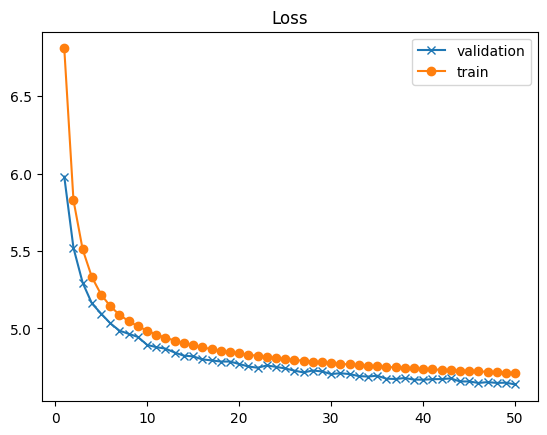

smallest val loss: (50, 4.6374493)


{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [55]:
hist(history)
params

you can use more data or more regularization to avoid the overfitting

In [97]:
print(clean_words(longreview_val['long'][i3]))
print()
print(summarize(clean_words(longreview_val['long'][i3])))

wb phase  polling records  voter turnout

the west bengal assembly on saturday announced that the election commission has been declared in the state assembly elections in the state assembly elections the poll was held in the state assembly elections the poll was held in the assembly elections the ec also announced that the ec will be able to <UNK> seats in the state
